# Siamese Neural Network RC Data

In [1]:
from time import time
from pathlib import Path
import pickle
import copy

import pandas as pd
from pandas.api.types import is_string_dtype
import numpy as np

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import firebase_admin
import google.cloud
from firebase_admin import credentials, firestore, db

## Preprocessing

In [2]:
DATA_PATH = Path("../rc_simulator/data")
CREDENTIALS_PATH = "../../resources/firebase_credentials.json"

# Variables for simulations
SIMULATION_DATA = False
TRAIN_DATA = str(DATA_PATH.joinpath("races_train.pickle"))
TEST_DATA = str(DATA_PATH.joinpath("races_test.pickle"))

# Timeseries variables
WINDOW = 20

In [3]:
if not SIMULATION_DATA:
    cred = credentials.Certificate(CREDENTIALS_PATH)
    app = firebase_admin.initialize_app(cred, options=dict(databaseURL='https://zippy-chain-232108.firebaseio.com/'))

In [4]:
if SIMULATION_DATA:
    with open(TRAIN_DATA, "rb") as f:
        train_data = pickle.load(f)

    with open(TEST_DATA, "rb") as f:
        test_data = pickle.load(f)
else:
    store = firestore.client()

    agressive_doc_ref = store.collection(u'user-race/Nvz1IDUFi5CTrhTR3qUS/events')
    relaxed_doc_ref = store.collection(u'user-race/1mJCR3M9oW60O5WVTLek/events')
    unattentive_doc_ref = (db.reference(u'user-race/1553185359264-f4127597-904b-f4e0-1e96-4e700c60bfc0/events'), 
                           db.reference(u'user-race/1553185885214-90456e9b-e7ac-d121-7acb-3424e51f5850/events'))
                                  
    agressive_data = [a.to_dict() for a in agressive_doc_ref.get() ]
    relaxed_data = [a.to_dict() for a in relaxed_doc_ref.get() ]
    unattentive_data = list(unattentive_doc_ref[0].get().values()) + list(unattentive_doc_ref[1].get().values())

In [5]:
def collection_to_df(firestore_collection, label):
    df = pd.DataFrame(firestore_collection)
    df = df.assign(label=[label]*df.shape[0])
    return df
    
def pickle_to_df(pickle_dict):
    actions_df = pd.DataFrame() # Actions + label
    reactions_df = pd.DataFrame() # Reactions + label

    for i, instance in enumerate(pickle_dict):
        current_reactions_df = pd.DataFrame(instance["reactions"])
        current_reactions_df = current_reactions_df.assign(race=[i]*current_reactions_df.shape[0], 
                                                       label=[instance["label"]]*current_reactions_df.shape[0])

        current_acctions_df = pd.DataFrame(instance["actions"])
        current_acctions_df = current_acctions_df.assign(race=[i]*current_reactions_df.shape[0], 
                                                      label=[instance["label"]]*current_reactions_df.shape[0])

        actions_df = actions_df.append(current_acctions_df)
        reactions_df = reactions_df.append(current_reactions_df)
    return reactions_df, actions_df

In [6]:
if SIMULATION_DATA:
    train_df, _ = pickle_to_df(train_data)
    test_df, _ = pickle_to_df(test_data)
else:
    agressive_df = collection_to_df(agressive_data, "agressive")
    relaxed_df = collection_to_df(agressive_data, "relaxed")
    unattentive_df = collection_to_df(unattentive_data, "unattentive")
    all_profiles_df = agressive_df.append(relaxed_df)
    all_profiles_df = all_profiles_df.append(unattentive_df)

In [7]:
def preprocess(df):
    drop_cols = ["acceleration_x", "acceleration_y", "acceleration_z", 
                 "gyroskop_x", "gyroskop_y", "gyroskop_z", "time_double", 
                 "rccarid", "start_lap", "lapcount", "capturetime", "time_double", "driverid", "end_lap"]
    after_process = df.drop(drop_cols, axis=1)
    return after_process

In [8]:
if SIMULATION_DATA:
    train_df = preprocess(train_df)
    test_df = preprocess(test_df)
else:
    train_df = preprocess(all_profiles_df)

In [9]:
train_df.head()

,acceleration_x_scaled,acceleration_y_scaled,acceleration_z_scaled,gyroskop_x_scaled,gyroskop_y_scaled,gyroskop_z_scaled,rpm,label
0,-0.256836,0.134277,1.074219,-3.885496,-1.954198,1.862595,0.000000,agressive
1,-0.202881,0.235596,1.128662,13.290076,11.748092,-15.832061,235.961381,agressive
2,-0.098389,0.307617,0.953613,15.206107,-17.114504,-87.534351,215.012021,agressive
3,0.190430,0.112549,0.654053,35.389313,4.648855,-84.053435,0.000000,agressive
4,-0.261475,0.139160,1.074463,-3.816794,-0.083969,0.053435,0.000000,agressive


## Prepare the data

In [10]:
def df_to_X_y_seq(df, seq_len):
    X = []
    y = []

    for start, end in zip(np.arange(0, df.shape[0] - seq_len, seq_len), np.arange(seq_len, df.shape[0], seq_len)):
        X.append(df.iloc[start:end,:-1].values)
        y.append(df.iloc[start:end,-1].mode()[0])
        
    X = np.array(X)
    y = np.array(y)
    return X, y

In [11]:
if SIMULATION_DATA:
    X, y = df_to_X_y_seq(train_df, WINDOW)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=42)
    X_test, y_test = df_to_X_y_seq(test_df, WINDOW)
else:
    X, y = df_to_X_y_seq(train_df, WINDOW)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

## Build the Siamese NN with LSTM

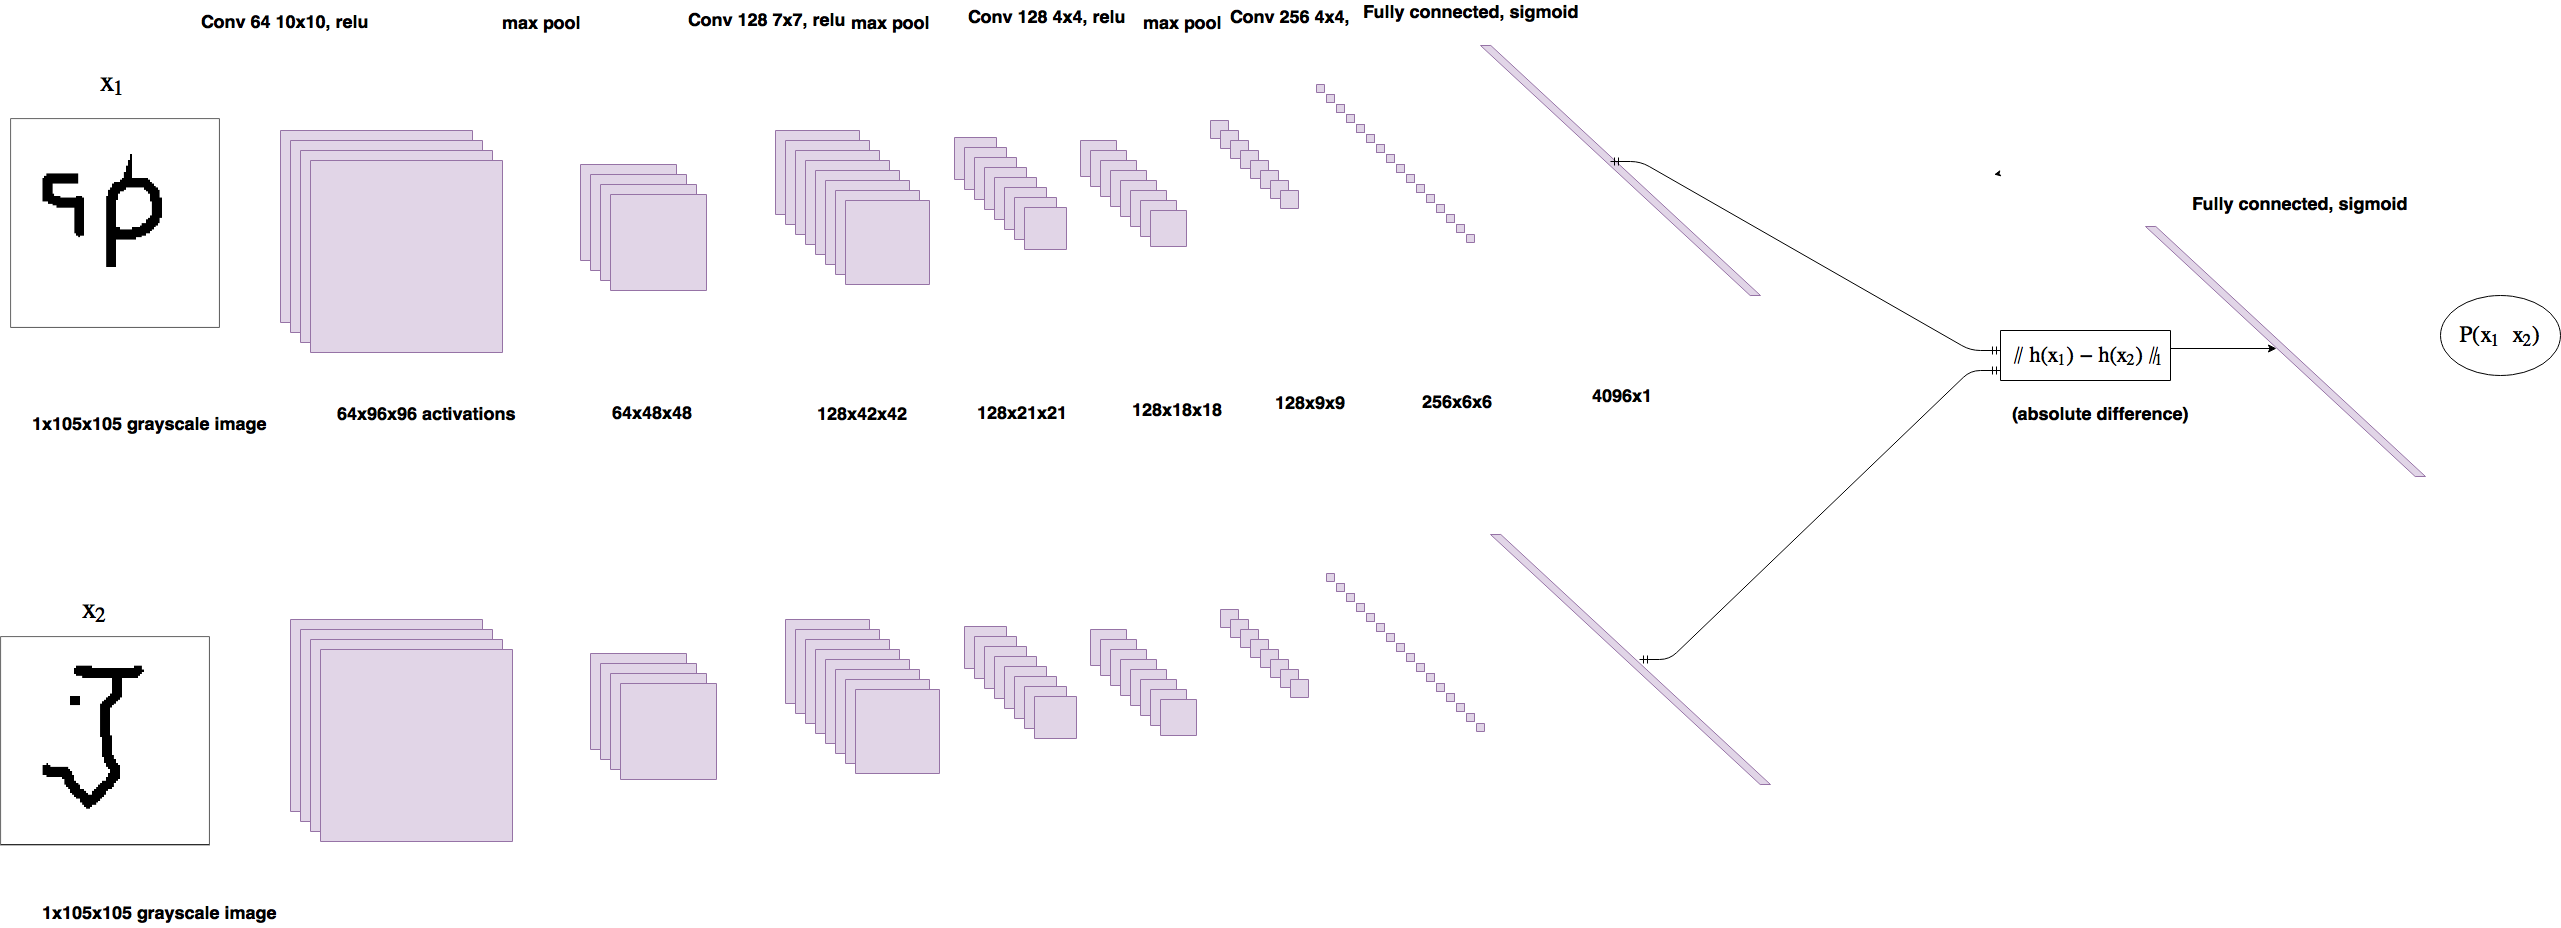

Define the input shape

In [12]:
max_seq_length = WINDOW
features =  7

In [13]:
input_shape = (max_seq_length, features, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

Build the twins neural networks

In [14]:
convnet = Sequential()

convnet.add(Conv2D(256, (5, 2), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())

convnet.add(Conv2D(128, (5, 2), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())

convnet.add(Conv2D(256, (2, 1), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(Flatten())

convnet.add(Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3),))

In [15]:
convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 6, 256)        2816      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 3, 256)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 2, 128)         327808    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 1, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 256)         65792     
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 4096)              1052672   
Total para

Merge the twin nn and calculate the distance between their outputs

In [16]:
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
    
prediction = Dense(1, activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

siamese_net.compile(loss="binary_crossentropy", optimizer=Adam(0.00006))

In [17]:
siamese_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 7, 1)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 20, 7, 1)     0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         1449088     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[1][0]                 
          

## Training

In [18]:
class SiameseLoader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, data, categories):
        self.data = data
        self.categories = categories
        self.info = {}
        
    def get_batch(self, batch_size, s="train"):
        """
        Create batch of n pairs, half same class, half different class
        
        Parameters
        ----------
        batch_size: int
            Number of pairs to create

        s: str
            Set name

        Returns
        -------
        tuple
            tuple[0] -> array like of shape (batch_size, 2, window_size, n_features, 1) containing the pairs of the batch
            tuple[1] -> array like of shape (batch_size) containing the targets. 
        """
        X = self.data[s]
        y = self.categories[s]
        
        n_seq, seq_length, n_features = X.shape

        # Initialize 2 empty arrays for the input image batch
        pairs = [np.zeros((batch_size, seq_length, n_features, 1)) for i in range(2)]
        
        # Initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets = np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        labels = []
        for i in range(batch_size):
            idx_1 = np.random.randint(0, n_seq)
            pairs[0][i,:,:,:] = X[idx_1].reshape(seq_length, n_features, 1)
            pair_0_label = y[idx_1]
                        
            # Pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                idx_2 = np.random.choice([l[0] for l in enumerate(y) if l[1] == pair_0_label])
            else: 
                idx_2 = np.random.choice([l[0] for l in enumerate(y) if l[1] != pair_0_label])
            
            labels.append((pair_0_label, y[idx_2]))
            
            pairs[1][i,:,:,:] = X[idx_2].reshape(seq_length, n_features, 1)
            
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """A generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size, s)
            yield (pairs, targets)    
            
    def make_oneshot_task(self, s="val", N=10):
        """
        Create pairs of test image, support set for testing N way one-shot learning. 
        
        Parametes
        ---------
        s: str, optional
            Name of the used set
        N: int, optional
            Support set size

        Returns
        -------
        tuple
            tuple[0] -> array like of shape (batch_size, 2, window_size, n_features, 1) containing the pairs of the batch
                        Paris where first element is the test image and the second one is an instance of the support set
            tuple[1] -> array like of shape (batch_size) with a single 1, which is the target of support set
        """
        X = self.data[s]
        y = self.categories[s]
        enum_labels = list(enumerate(y))

        n_seq, seq_length, n_features = X.shape
    
        # Pick the true label
        true_label = np.random.choice(y)
        true_instances = np.array([l[0] for l in enum_labels if l[1] == true_label]).astype(np.int)
        false_instances = np.array([l[0] for l in enum_labels if l[1] != true_label]).astype(np.int)

        # Build the support set
        support_set_idx = np.random.choice(false_instances, size=(N), replace=False)        
        support_set = X[support_set_idx].reshape(N, seq_length, n_features, 1)
        test_img_idx, support_true_idx = np.random.choice(true_instances, size=(2,), replace=False)
        support_set[0,:,:,:] = X[support_true_idx].reshape(seq_length, n_features, 1)
        
        # Pick the same test image N times
        test_img = [X[test_img_idx].reshape(seq_length, n_features, 1)]*N
        
        # Set the first target to 1 because the first element of support set is the desired output
        targets = np.zeros((N,))
        targets[0] = 1
        
        targets, test_img, support_set = shuffle(targets, test_img, support_set)
        pairs = [test_img, support_set]
        
        return pairs, targets
    
    def test_oneshot(self, model, k, s="val", verbose=0):
        """
        Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks
        
        Parameters
        ----------
        model: kearas.model
        
        k: int
            Number of one shot tasks
        s: str, optional
            Name of the set
        verbose: boolean, optional
            If True -> print the accuracy
        
        Returns
        -------
        float
            Accuaracy on the k one shot tasks
        """
        n_correct = 0
        for i in range(k):
            inputs, targets = self.make_oneshot_task(s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct += 1
        percent_correct = (100.0 * n_correct / k)
        if verbose:
            print("Got an average of {}% learning accuracy".format(percent_correct))
        return percent_correct
    
loader = SiameseLoader(data={"train": X, "val": X_val}, categories={"train": y, "val": y_val})        

In [19]:
n_iter = 10000
loss_every = 500
weights_path = "siamese_net.h5"
batch_size = 20

best_loss = 99999
for i in range(1, n_iter):
    (inputs, targets) = loader.get_batch(batch_size)
    loss = siamese_net.train_on_batch(inputs, targets)
    
    if i % loss_every == 0:
        print("Iteration {}, Loss: {}".format(i, loss))
        val_acc = loader.test_oneshot(siamese_net, 30, verbose=True)
        
        # If loss improve store the weights
        if best_loss > loss:
            best_loss = loss
            siamese_net.save(weights_path)

Iteration 500, Loss: 0.6667858958244324
Got an average of 46.666666666666664% learning accuracy
Iteration 1000, Loss: 0.5407374501228333
Got an average of 43.333333333333336% learning accuracy
Iteration 1500, Loss: 0.4268416166305542
Got an average of 90.0% learning accuracy
Iteration 2000, Loss: 0.21031098067760468
Got an average of 100.0% learning accuracy
Iteration 2500, Loss: 0.201625257730484
Got an average of 100.0% learning accuracy
Iteration 3000, Loss: 0.14533846080303192
Got an average of 100.0% learning accuracy
Iteration 3500, Loss: 0.11544772237539291
Got an average of 100.0% learning accuracy
Iteration 4000, Loss: 0.13680626451969147
Got an average of 100.0% learning accuracy
Iteration 4500, Loss: 0.08342255651950836
Got an average of 100.0% learning accuracy
Iteration 5000, Loss: 0.0733705386519432
Got an average of 100.0% learning accuracy
Iteration 5500, Loss: 0.08629626035690308
Got an average of 100.0% learning accuracy
Iteration 6000, Loss: 0.06153639405965805
Got a

## Making predictions

Generate the set that will be used to make predictions

In [20]:
all_X = np.concatenate((X, X_val))
examples, seq_len, features = all_X.shape
all_X = all_X[:].reshape(examples, seq_len, features, 1)
all_y = np.concatenate((y, y_val))

np.savez("prediction_set.npz", y=all_y, X=all_X)

In [21]:
def predict(model, serie, prediction_set):
    """
    Parameters
    ----------
    model: keras.model
    
    serie: array of shape (200, 7)
    
    Returns
    -------
    tuple
        tuple[0] -> label of the `serie`
        tuple[1] -> max probability of each class
    """
    
    # Pair the serie with each instance in the prdiction set
    pairs = [[serie.reshape(seq_len, features, 1)]*len(prediction_set["X"]), prediction_set["X"]]
    
    # Calculate the probabilities
    probs = model.predict(pairs)
    
    probs_label = list(zip(probs.flatten(), prediction_set["y"]))
    max_probs = dict()
    for l in np.unique(prediction_set["y"]):
        current_probs = [p[0] for p in probs_label if p[1] == l]
        max_probs[l] = np.mean(current_probs)
        
    # Get the max probabily and get the corresponding label
    return prediction_set["y"][np.argmax(probs.flatten())], max_probs

In [22]:
y_true = y_test.tolist()
y_pred = [ predict(siamese_net, i, np.load("prediction_set.npz"))[0] for i in X_test ]
target_names = np.unique(y_true).tolist()
    
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   agressive       1.00      1.00      1.00        28
     relaxed       1.00      1.00      1.00        30
 unattentive       1.00      1.00      1.00        24

   micro avg       1.00      1.00      1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



In [27]:
y_test[0], predict(siamese_net, X_test[0], np.load("prediction_set.npz"))

('unattentive',
 ('unattentive',
  {'agressive': 0.00015271436,
   'relaxed': 7.002893e-05,
   'unattentive': 0.9965905}))

## Making predictions loading the model from weights

In [3]:
weights_path = "siamese_net.h5"

siamese_net.load_weights(weights_path)

y_true = y_test.tolist()
y_pred = [ predict(siamese_net, i, np.load("prediction_set.npz"))[0] for i in X_test ]
target_names = np.unique(y_true).tolist()
    
print(classification_report(y_true, y_pred, target_names=target_names))

NameError: name 'siamese_net' is not defined

In [2]:
list(zip(y_true, y_pred))

NameError: name 'y_true' is not defined